In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [18]:
data = pd.read_csv('/Users/simonlipson/Downloads/aflstats/stats.csv')

In [3]:
data.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.0,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.0,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.0,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.0,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.0,...,0,0,8,14,0,0,9,1,0,93


In [11]:
data['Round'].value_counts()

R19    2772
R4     2772
R1     2772
R16    2772
R17    2772
R3     2772
R7     2772
R21    2772
R22    2772
R23    2772
R5     2772
R18    2772
R2     2772
R20    2772
R6     2772
R8     2640
R15    2640
R10    2596
R9     2596
R14    2464
R11    2244
R12    2200
R13    1980
PF      616
EF      616
QF      616
SF      616
GF      308
Name: Round, dtype: int64

In [19]:
data = data.loc[~data['Round'].str.contains('F')]

In [20]:
data['season_player'] = data['Season'].astype(str) + data['Player'] 

In [21]:
data.columns

Index(['Team', 'Player', 'D.O.B', 'Height', 'Weight', 'Position', 'Season',
       'Round', 'Date', 'Score', 'Margin', 'WinLoss', 'Opposition', 'Venue',
       'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds',
       'Hitouts', 'Tackles', 'Rebound50s', 'Inside50s', 'Clearances',
       'Clangers', 'FreesFor', 'FreesAgainst', 'BrownlowVotes',
       'ContendedPossessions', 'UncontendedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists',
       'PercentPlayed', 'season_player'],
      dtype='object')

In [43]:
def engineer_features(df):

    return df.groupby('season_player').agg(
    brownlowvotes = pd.NamedAgg(column = 'BrownlowVotes', aggfunc = 'sum'),
    disposals = pd.NamedAgg(column = 'Disposals', aggfunc = 'sum'),
    kicks = pd.NamedAgg(column = 'Kicks', aggfunc = 'sum'),
    marks = pd.NamedAgg(column = 'Marks', aggfunc = 'sum'),
    handballs = pd.NamedAgg(column = 'Handballs', aggfunc = 'sum'),
    hitouts = pd.NamedAgg(column = 'Hitouts', aggfunc = 'sum'),
    goals = pd.NamedAgg(column = 'Goals', aggfunc = 'sum'),
    behinds = pd.NamedAgg(column = 'Behinds', aggfunc = 'sum'),
    tackles = pd.NamedAgg(column = 'Tackles', aggfunc = 'sum'),
    rebound50s = pd.NamedAgg(column = 'Rebound50s', aggfunc = 'sum'),
    inside50s = pd.NamedAgg(column = 'Inside50s', aggfunc = 'sum'),
    clearances = pd.NamedAgg(column = 'Clearances', aggfunc = 'sum'),
    clangers = pd.NamedAgg(column = 'Clangers', aggfunc = 'sum'),
    freesfor = pd.NamedAgg(column = 'FreesFor', aggfunc = 'sum'),
    freesagainst = pd.NamedAgg(column = 'FreesAgainst', aggfunc = 'sum'),
    contendedpossessions = pd.NamedAgg(column = 'ContendedPossessions', aggfunc = 'sum'),
    uncontendedpossessions = pd.NamedAgg(column = 'UncontendedPossessions', aggfunc = 'sum'),
    contestedmarks = pd.NamedAgg(column = 'ContestedMarks', aggfunc = 'sum'),
    marksinside50 = pd.NamedAgg(column = 'MarksInside50', aggfunc = 'sum'),
    oncepercenters = pd.NamedAgg(column = 'OnePercenters', aggfunc = 'sum'),
    bounces = pd.NamedAgg(column = 'Bounces', aggfunc = 'sum'),
    goalassist = pd.NamedAgg(column = 'GoalAssists', aggfunc = 'sum'),
    percentplayed = pd.NamedAgg(column = 'PercentPlayed', aggfunc = np.mean),
    )

In [44]:
features = engineer_features(data)

In [45]:
features.head()

,brownlowvotes,disposals,kicks,marks,handballs,hitouts,goals,behinds,tackles,rebound50s,...,freesfor,freesagainst,contendedpossessions,uncontendedpossessions,contestedmarks,marksinside50,oncepercenters,bounces,goalassist,percentplayed
season_player,,,,,,,,,,,,,,,,,,,,,
"2012Ablett, Gary",24,675,389,61,286,0,26,19,110,61,...,41,28,298,368,14,13,32,31,19,92.450000
"2012Adams, Leigh",4,344,180,50,164,1,17,15,59,12,...,16,15,134,196,2,8,32,0,15,75.166667
"2012Adams, Taylor",0,298,167,51,131,0,5,1,53,29,...,18,16,122,179,1,1,17,3,4,76.666667
"2012Adcock, Jed",0,404,244,104,160,0,3,2,85,81,...,25,15,111,274,5,2,65,1,11,88.714286
"2012Addison, Dylan",0,232,129,81,103,0,7,5,40,25,...,11,16,83,156,14,7,51,3,0,90.000000


In [46]:
features.shape

(4649, 23)

In [47]:
def get_year_stats(x):

    return pd.read_html('https://afltables.com/afl/stats/{}.html'.format(x))

In [48]:
def combine_team_tables(df, year, clubs):
    
    frames = []
    for i in range(1,clubs):
        frames.append(df[i].iloc[:-1])
    
    for i in range(len(frames)): 
        frames[i].columns = frames[i].columns.get_level_values(1)
        
    df = pd.concat(frames, axis=0, ignore_index = True)
    
    df['Season'] = year
    
    df['season_player'] = df['Season'] + df['Player']
    
    return df

In [49]:
def normalize_columns(df):

    return df.rename(columns={'BR': 'BrownlowVotes',
                                     'DI': 'Disposals',
                                     'KI': 'Kicks',
                                     'MK': 'Marks',
                                     'HB': 'Handballs',
                                     'HO': 'Hitouts',
                                     'GL': 'Goals',
                                     'BH': 'Behinds',
                                     'TK': 'Tackles',
                                     'RB': 'Rebound50s',
                                     'IF': 'Inside50s',
                                     'CL': 'Clearances',
                                     'CG': 'Clangers',
                                     'FF': 'FreesFor',
                                     'FA': 'FreesAgainst',
                                     'CP': 'ContendedPossessions',
                                     'UP': 'UncontendedPossessions',
                                     'CM': 'ContestedMarks',
                                     'MI': 'MarksInside50',
                                     '1%': 'OnePercenters',
                                     'BO': 'Bounces',
                                     'GA': 'GoalAssists',
                                     '%P': 'PercentPlayed'}, inplace=True)

In [50]:
def feature_engineering_pipeline(year, clubs):
    
    df = combine_team_tables(get_year_stats(year), year, clubs)
    normalize_columns(df)
    return engineer_features(df)

In [51]:
missing_years_16_clubs = [str(i) for i in range(2003,2011)]
missing_2011 = '2011'
missing_2019 = '2019'

In [52]:
new_data = []
for year in missing_years_16_clubs:
    globals()['data_' + year] = feature_engineering_pipeline(year, 17)
    new_data.append(globals()['data_' + year])

In [53]:
data_2011 = feature_engineering_pipeline('2011', 18)
data_2019 = feature_engineering_pipeline('2019', 19)

new_data.append(data_2011)
new_data.append(data_2019)
new_data.append(features)


In [54]:
all_data_2003_2019 = pd.concat(new_data, axis=0, ignore_index = False)

all_data_2003_2019.head()

,brownlowvotes,disposals,kicks,marks,handballs,hitouts,goals,behinds,tackles,rebound50s,...,freesfor,freesagainst,contendedpossessions,uncontendedpossessions,contestedmarks,marksinside50,oncepercenters,bounces,goalassist,percentplayed
season_player,,,,,,,,,,,,,,,,,,,,,
"2003Ablett, Gary",3.0,327.0,189.0,61.0,138.0,0.0,26.0,20.0,77.0,14.0,...,21.0,11.0,185.0,163.0,6.0,11.0,42.0,30.0,11.0,93.7
"2003Ablett, Luke",0.0,17.0,10.0,6.0,7.0,0.0,1.0,0.0,0.0,3.0,...,0.0,1.0,7.0,11.0,1.0,1.0,2.0,0.0,0.0,29.5
"2003Adkins, Damien",0.0,59.0,46.0,16.0,13.0,0.0,7.0,6.0,8.0,1.0,...,2.0,3.0,18.0,42.0,2.0,4.0,6.0,1.0,1.0,49.8
"2003Akermanis, Jason",5.0,452.0,350.0,99.0,102.0,0.0,28.0,32.0,84.0,32.0,...,13.0,23.0,173.0,260.0,6.0,18.0,28.0,40.0,19.0,88.5
"2003Alessio, Steven",0.0,138.0,90.0,43.0,48.0,170.0,9.0,6.0,12.0,11.0,...,9.0,17.0,79.0,57.0,7.0,12.0,15.0,0.0,4.0,57.2


In [55]:
all_data_2003_2019.isnull().sum()

brownlowvotes             0
disposals                 0
kicks                     0
marks                     0
handballs                 0
hitouts                   0
goals                     0
behinds                   0
tackles                   0
rebound50s                0
inside50s                 0
clearances                0
clangers                  0
freesfor                  0
freesagainst              0
contendedpossessions      0
uncontendedpossessions    0
contestedmarks            0
marksinside50             0
oncepercenters            0
bounces                   0
goalassist                0
percentplayed             0
dtype: int64

In [56]:
years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [57]:
X_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    X_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,1:23])

In [58]:
y_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    y_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,0])

In [59]:
X_test = []

for year in years:

    X_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,1:23])

In [60]:
y_test = []

for year in years:
    
    y_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,0])

In [61]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GBM', GradientBoostingRegressor()))


results = []
names = []
print('Model r2 results:')
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train[0], y_train[0], cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model r2 results:
LR: 0.615737 (0.026228)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


LASSO: 0.604914 (0.026351)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


EN: 0.612446 (0.026337)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


KNN: 0.664463 (0.024496)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


CART: 0.454048 (0.063452)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GBM: 0.715398 (0.029727)


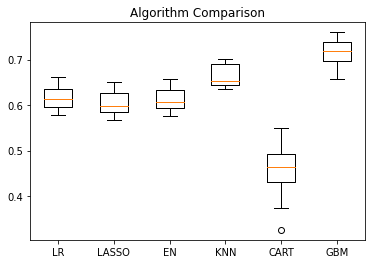

In [62]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [152]:
model = KNeighborsRegressor()
results = []
for i in range(len(X_test)):
    model.fit(X_train[i], y_train[i])
    y_pred = model.predict(X_test[i])
    results.append(pd.DataFrame({'actual': y_test[i],
                                'prediction': y_pred})
                  .sort_values('prediction', ascending=False).reset_index())

In [153]:
joined_results = pd.concat(results, axis = 1)

In [154]:
top5 = joined_results['season_player'].head()
top5.columns = years
top5

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"2003Black, Simon","2004Brown, Nathan","2005Judd, Chris","2006West, Scott","2007Mitchell, Sam","2008Corey, Joel","2009Swan, Dane","2010Ablett, Gary","2011Swan, Dane","2012Thompson, Scott","2013Swan, Dane","2014Priddis, Matt","2015Dangerfield, Patrick","2016Dangerfield, Patrick","2017Mitchell, Tom","2018Mitchell, Tom","2019Kelly, Tim"
1,"2003Buckley, Nathan","2004Judd, Chris","2005Kirk, Brett","2006Judd, Chris","2007Ablett, Gary","2008Selwood, Joel","2009Thompson, Scott","2010Swan, Dane","2011Mitchell, Sam","2012Boyd, Matthew","2013Ablett, Gary","2014Dangerfield, Patrick","2015Hannebery, Dan","2016Martin, Dustin","2017Martin, Dustin","2018Cunnington, Ben","2019Dangerfield, Patrick"
2,"2003Hasleby, Paul","2004Tredrea, Warren","2005Cousins, Ben","2006Black, Simon","2007Corey, Joel","2008Mitchell, Sam","2009Selwood, Joel","2010Thompson, Scott","2011Thompson, Scott","2012Kennedy, Josh P","2013Kennedy, Josh P","2014Cotchin, Trent","2015Pendlebury, Scott","2016Priddis, Matt","2017Crouch, Matt","2018Cripps, Patrick","2019Bontempelli, Marcus"
3,"2003Cousins, Ben","2004Ricciuto, Mark","2005Hodge, Luke","2006Goodwin, Simon","2007Simpson, Adam","2008Franklin, Lance","2009Ablett, Gary","2010Kennedy, Josh","2011Judd, Chris","2012Watson, Jobe","2013Pendlebury, Scott","2014Gray, Robbie","2015Gray, Robbie","2016Hannebery, Dan","2017Dangerfield, Patrick","2018Neale, Lachie","2019Kennedy, Josh"
4,"2003Ricciuto, Mark","2004Black, Simon","2005Hall, Barry","2006Hall, Barry","2007Lynch, Quinten","2008Ablett, Gary","2009Corey, Joel","2010Boyd, Matthew","2011Pendlebury, Scott","2012Ablett, Gary","2013Griffen, Ryan","2014Selwood, Joel","2015Selwood, Joel","2016Ward, Callan","2017Ross, Sebastian","2018Oliver, Clayton","2019Treloar, Adam"


In [146]:
def in_statements(val):
    color = 'red' if val in winners else 'black'
    return 'color: %s' % color

In [148]:
winners = ['2003Buckley, Nathan', '2003Ricciuto, Mark', '2003Goodes, Adam',
          '2004Judd, Chris',
          '2005Cousins, Ben',
          '2006Goodes, Adam',
          '2007Bartel, Jimmy',
          '2008Cooney, Adam',
          '2009Ablett, Gary',
          '2010Judd, Chris',
          '2011Swan, Dane',
          '2012Watson, Jobe',
          '2013Ablett, Gary',
          '2014Priddis, Matt',
          '2015Fyfe, Nat',
          '2016Dangerfield, Patrick',
          '2017Martin, Dustin',
          '2018Mitchell, Tom',
          '2019Fyfe, Nat']

In [151]:
##Results for Linear Regression
top5.head().style.applymap(in_statements)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"2003Buckley, Nathan","2004Brown, Nathan","2005Cousins, Ben","2006Judd, Chris","2007Ablett, Gary","2008Cooney, Adam","2009Ablett, Gary","2010Ablett, Gary","2011Murphy, Marc","2012Dangerfield, Patrick","2013Ablett, Gary","2014Selwood, Joel","2015Dangerfield, Patrick","2016Dangerfield, Patrick","2017Martin, Dustin","2018Cripps, Patrick","2019Kelly, Tim"
1,"2003Black, Simon","2004Black, Simon","2005Judd, Chris","2006Goodwin, Simon","2007Corey, Joel","2008Ablett, Gary","2009Swan, Dane","2010Montagna, Leigh","2011Swan, Dane","2012Ablett, Gary","2013Pendlebury, Scott","2014Dangerfield, Patrick","2015Gray, Robbie","2016Parker, Luke","2017Dangerfield, Patrick","2018Dangerfield, Patrick","2019Neale, Lachie"
2,"2003West, Scott","2004Lappin, Nigel","2005West, Scott","2006West, Scott","2007Mitchell, Sam","2008Thompson, Scott","2009Boyd, Matthew","2010Boyd, Matthew","2011Kennedy, Josh","2012Cotchin, Trent","2013Swan, Dane","2014Pendlebury, Scott","2015Fyfe, Nat","2016Kennedy, Josh P","2017Mitchell, Tom","2018Mitchell, Tom","2019Treloar, Adam"
3,"2003Hasleby, Paul","2004Judd, Chris","2005Hodge, Luke","2006Mitchell, Sam","2007Pavlich, Matthew","2008Corey, Joel","2009Judd, Chris","2010Swan, Dane","2011Ablett, Gary","2012Watson, Jobe","2013Kennedy, Josh P","2014Gray, Robbie","2015Kennedy, Josh P","2016Hannebery, Dan","2017Fyfe, Nat","2018Martin, Dustin","2019Lynch, Tom"
4,"2003Cousins, Ben","2004West, Scott","2005Kirk, Brett","2006Johnson, Brad","2007Cornes, Chad","2008Mitchell, Sam","2009Dal Santo, Nick","2010Goddard, Brendon","2011Mitchell, Sam","2012Kennedy, Josh P","2013Selwood, Joel","2014Ablett, Gary","2015Priddis, Matt","2016Treloar, Adam","2017Parker, Luke","2018Ward, Callan","2019Reid, Sam"


In [ ]:
importance = model.coef_
for i,v in enumerate(importance):
	print('{}, Score: {}'.format(X_test[0].columns[i],v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [150]:
##Results for Gradient Boosting 
top5.head().style.applymap(in_statements)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"2003Buckley, Nathan","2004Brown, Nathan","2005Cousins, Ben","2006Judd, Chris","2007Ablett, Gary","2008Cooney, Adam","2009Ablett, Gary","2010Ablett, Gary","2011Murphy, Marc","2012Dangerfield, Patrick","2013Ablett, Gary","2014Selwood, Joel","2015Dangerfield, Patrick","2016Dangerfield, Patrick","2017Martin, Dustin","2018Cripps, Patrick","2019Kelly, Tim"
1,"2003Black, Simon","2004Black, Simon","2005Judd, Chris","2006Goodwin, Simon","2007Corey, Joel","2008Ablett, Gary","2009Swan, Dane","2010Montagna, Leigh","2011Swan, Dane","2012Ablett, Gary","2013Pendlebury, Scott","2014Dangerfield, Patrick","2015Gray, Robbie","2016Parker, Luke","2017Dangerfield, Patrick","2018Dangerfield, Patrick","2019Neale, Lachie"
2,"2003West, Scott","2004Lappin, Nigel","2005West, Scott","2006West, Scott","2007Mitchell, Sam","2008Thompson, Scott","2009Boyd, Matthew","2010Boyd, Matthew","2011Kennedy, Josh","2012Cotchin, Trent","2013Swan, Dane","2014Pendlebury, Scott","2015Fyfe, Nat","2016Kennedy, Josh P","2017Mitchell, Tom","2018Mitchell, Tom","2019Treloar, Adam"
3,"2003Hasleby, Paul","2004Judd, Chris","2005Hodge, Luke","2006Mitchell, Sam","2007Pavlich, Matthew","2008Corey, Joel","2009Judd, Chris","2010Swan, Dane","2011Ablett, Gary","2012Watson, Jobe","2013Kennedy, Josh P","2014Gray, Robbie","2015Kennedy, Josh P","2016Hannebery, Dan","2017Fyfe, Nat","2018Martin, Dustin","2019Lynch, Tom"
4,"2003Cousins, Ben","2004West, Scott","2005Kirk, Brett","2006Johnson, Brad","2007Cornes, Chad","2008Mitchell, Sam","2009Dal Santo, Nick","2010Goddard, Brendon","2011Mitchell, Sam","2012Kennedy, Josh P","2013Selwood, Joel","2014Ablett, Gary","2015Priddis, Matt","2016Treloar, Adam","2017Parker, Luke","2018Ward, Callan","2019Reid, Sam"


disposals, Score: 0.09889136553669091
kicks, Score: 0.08012964868800153
marks, Score: 0.006849325905869452
handballs, Score: 0.0020262128543567614
hitouts, Score: 0.010754440099845981
goals, Score: 0.06494304429549287
behinds, Score: 0.0022871098773397268
tackles, Score: 0.007538522991652475
rebound50s, Score: 0.0012247012316962992
inside50s, Score: 0.08610839464361582
clearances, Score: 0.05968302686680709
clangers, Score: 0.0020902558338465787
freesfor, Score: 0.004446645784928948
freesagainst, Score: 0.0006398740815139328
contendedpossessions, Score: 0.5078843763254424
uncontendedpossessions, Score: 0.003200482569203377
contestedmarks, Score: 0.01260302324514513
marksinside50, Score: 0.009711409214774236
oncepercenters, Score: 0.004936365301431389
bounces, Score: 0.008197933061942433
goalassist, Score: 0.007419398263821485
percentplayed, Score: 0.01843444332658125


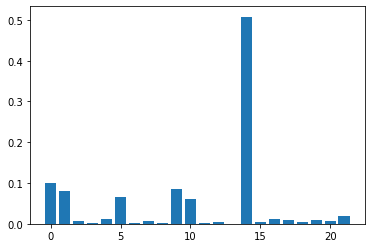

In [149]:
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('{}, Score: {}'.format(X_test[0].columns[i],v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [155]:
##Results for KNearest Neighbour Regression
top5.head().style.applymap(in_statements)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"2003Black, Simon","2004Brown, Nathan","2005Judd, Chris","2006West, Scott","2007Mitchell, Sam","2008Corey, Joel","2009Swan, Dane","2010Ablett, Gary","2011Swan, Dane","2012Thompson, Scott","2013Swan, Dane","2014Priddis, Matt","2015Dangerfield, Patrick","2016Dangerfield, Patrick","2017Mitchell, Tom","2018Mitchell, Tom","2019Kelly, Tim"
1,"2003Buckley, Nathan","2004Judd, Chris","2005Kirk, Brett","2006Judd, Chris","2007Ablett, Gary","2008Selwood, Joel","2009Thompson, Scott","2010Swan, Dane","2011Mitchell, Sam","2012Boyd, Matthew","2013Ablett, Gary","2014Dangerfield, Patrick","2015Hannebery, Dan","2016Martin, Dustin","2017Martin, Dustin","2018Cunnington, Ben","2019Dangerfield, Patrick"
2,"2003Hasleby, Paul","2004Tredrea, Warren","2005Cousins, Ben","2006Black, Simon","2007Corey, Joel","2008Mitchell, Sam","2009Selwood, Joel","2010Thompson, Scott","2011Thompson, Scott","2012Kennedy, Josh P","2013Kennedy, Josh P","2014Cotchin, Trent","2015Pendlebury, Scott","2016Priddis, Matt","2017Crouch, Matt","2018Cripps, Patrick","2019Bontempelli, Marcus"
3,"2003Cousins, Ben","2004Ricciuto, Mark","2005Hodge, Luke","2006Goodwin, Simon","2007Simpson, Adam","2008Franklin, Lance","2009Ablett, Gary","2010Kennedy, Josh","2011Judd, Chris","2012Watson, Jobe","2013Pendlebury, Scott","2014Gray, Robbie","2015Gray, Robbie","2016Hannebery, Dan","2017Dangerfield, Patrick","2018Neale, Lachie","2019Kennedy, Josh"
4,"2003Ricciuto, Mark","2004Black, Simon","2005Hall, Barry","2006Hall, Barry","2007Lynch, Quinten","2008Ablett, Gary","2009Corey, Joel","2010Boyd, Matthew","2011Pendlebury, Scott","2012Ablett, Gary","2013Griffen, Ryan","2014Selwood, Joel","2015Selwood, Joel","2016Ward, Callan","2017Ross, Sebastian","2018Oliver, Clayton","2019Treloar, Adam"


In [ ]:
importance = model.fea
for i,v in enumerate(importance):
	print('{}, Score: {}'.format(X_test[0].columns[i],v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()